# Homework 3: Reproducibility in Climate Studies

* **Statistics 159/259, Spring 2022**
* **Due 03/23/2023, 23:59PM PT**
* Prof. F. Pérez and GSI F. Sapienza, Department of Statistics, UC Berkeley.
* This assignment is worth a maximum of **50 points**.
* Assignment type: **group homework assignment** (Check on Ed Discussion about group's assignments).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

from pathlib import Path

# Small style adjustments for more readable plots
plt.style.use("seaborn-whitegrid")
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["font.size"] = 14

/tmp/ipykernel_2646/187724789.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


## 1. The Manua Loa CO2 data [15 points] 

For this first section, we will focus in reproducing Keeling's curve: 

<img src="figures/annual-anomaly-orig.png" width="700px" />

We start by loading the same dataset we used during the lecture, containing CO2 measurements in Mauna Loa, Hawaii. We get rid of missing values that are set to -99.99 and then drop from the dataset. Notice that the data for this homework has being already uploaded in our shared folder. 

In [2]:
DATA_DIR = Path.home()/Path('shared/climate-data')

co2_file = DATA_DIR / "monthly_in_situ_co2_mlo_cleaned.csv"
data = pd.read_csv(co2_file, na_values=-99.99).dropna()
data.head()

,year,month,date_index,fraction_date,c02,data_adjusted_season,data_fit,data_adjusted_seasonally_fit,data_filled,data_adjusted_seasonally_filed
2,1958,3,21259,1958.2027,315.70,314.43,316.19,314.90,315.70,314.43
3,1958,4,21290,1958.2877,317.45,315.16,317.30,314.98,317.45,315.16
4,1958,5,21320,1958.3699,317.51,314.71,317.86,315.06,317.51,314.71
6,1958,7,21381,1958.5370,315.86,315.19,315.86,315.22,315.86,315.19
7,1958,8,21412,1958.6219,314.93,316.19,313.99,315.29,314.93,316.19


This is how the data look like

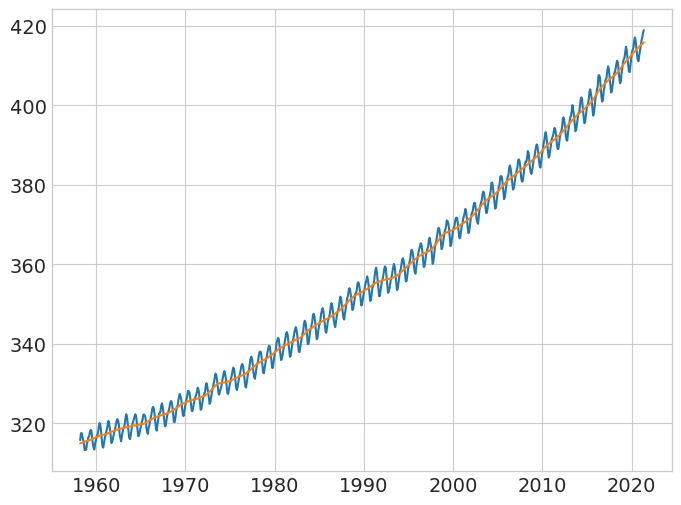

In [3]:
plt.plot("fraction_date", "c02", data=data)
plt.plot("fraction_date", "data_adjusted_seasonally_fit", data=data);

We are going to try to understand the annual variability on top of the growing trend, and see whether that variability is itself changing over time or not.

The figure above shows an annual cycle, alongside with perhaps some variability in it. Plants take up CO2 in (northern) spring/summer then release in fall/winter --- so the release is getting stronger. 

Let's try to estimate the increase in amplitude of annual cycle. A quick and simple `groupby` operation and removal of the annual mean result in this simple plot:

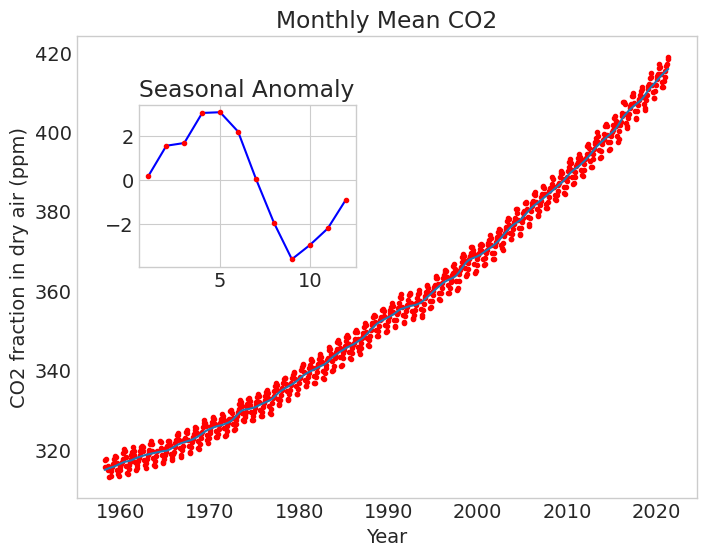

In [4]:
# calculate the anual cucle using groupby
annual = data.groupby(data.month).mean()

# calculate the anomaly
anomaly = annual - annual.mean()

# plot
fig, ax = plt.subplots()

ax.plot("fraction_date", "data_filled", "r.", data=data)
ax.plot("fraction_date", "data_adjusted_seasonally_fit", data=data)
ax.set_xlabel("Year")
ax.set_ylabel("CO2 fraction in dry air (ppm)")
ax.set_title("Monthly Mean CO2")
ax.grid(False)

axin1 = ax.inset_axes([0.1, 0.5, 0.35, 0.35])
axin1.plot(anomaly.c02, "b")
axin1.plot(anomaly.c02, "r.")
axin1.set_title("Seasonal Anomaly");

But if you look closely, that figure isn't quite the same as the one shown at the top. You can observe that the monthly variability is more smooth in the original figure and that is slightly shifted too. 

We'll start by trying to understand the monthly data. The following shows us the data for all the years, by month:

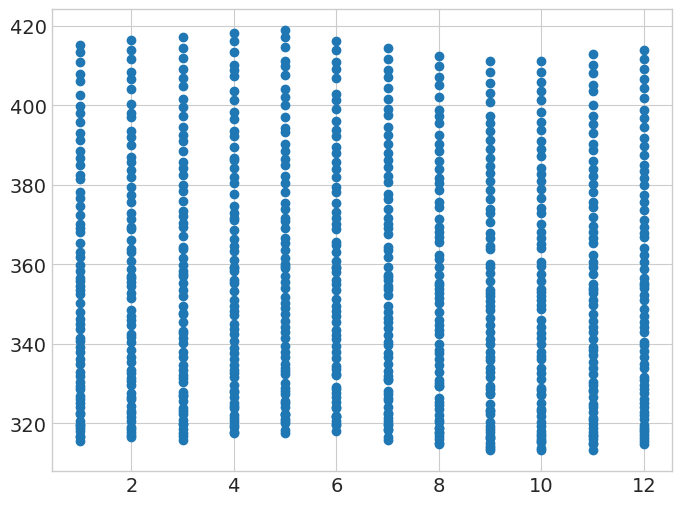

In [5]:
plt.scatter('month', 'c02', data=data);

Unfortunately it's hard to see what's actually going on here.

### Question 3 [5 points]

Next, recreate the following figure, which is much closer to the one in the lecture:

<img src="figures/annual-anomaly-new.png" width="700px" />

**Hints:** 
- in order to get that smooth curve, you'll need to use `from scipy.interpolate import CubicSpline`. You can find the documentation for `CubicSpline` [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.CubicSpline.html).
- The "Seasonal Anomaly" inset graph can be created with `ax.inset_axes(...)`. You can treat the `Axes` object returned like any other `Axes` object.
- Remember that you can set the tick labels with `ax.set_xticks(...)`.
- To get the data points plotted as red dots, when you use `ax.plot(...)`, pass in `"r."` as the argument immediately following any data you pass in. The `"r"` indicates the color, while the `"."` indicates how the data will be plotted (if you don't put the `"."`, it will be a line instead).

In [6]:
#SOLUTION FROM Q02

# Calculate the annual mean for each month
annual_means = data.groupby('year')['c02'].mean()

# Subtract the annual mean from each data point
data_copy = data.copy()
for year in data_copy['year'].unique():
    data_copy.loc[data_copy['year'] == year, 'c02'] -= annual_means[year]
    
# Calculate the monthly anomaly
monthly_anomaly = data_copy.groupby('month').mean()[['c02']]


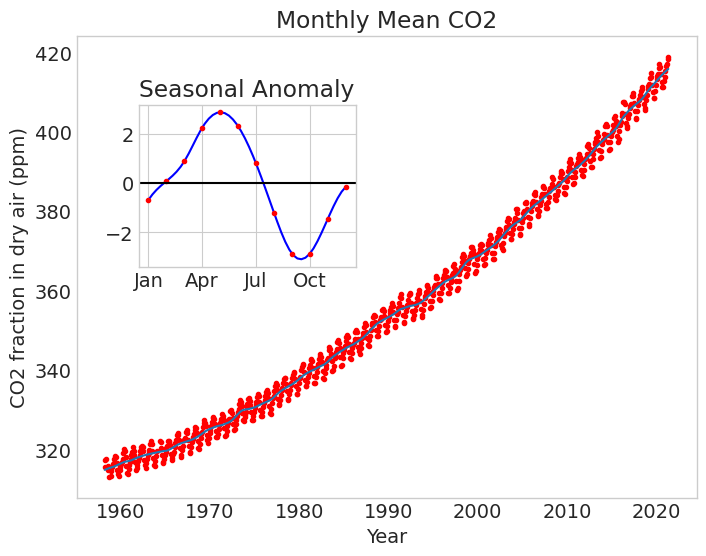

In [7]:
# BEGIN SOLUTION

from scipy.interpolate import CubicSpline

fig, ax = plt.subplots()

ax.plot("fraction_date", "data_filled", "r.", data=data)
ax.plot("fraction_date", "data_adjusted_seasonally_fit", data=data)
ax.set_xlabel("Year")
ax.set_ylabel("CO2 fraction in dry air (ppm)")
ax.set_title("Monthly Mean CO2")
ax.grid(False)

axin1 = ax.inset_axes([0.1, 0.5, 0.35, 0.35])  #inset_axes creates the smaller graph
space = np.linspace(1, 12) #continuous x-axis rather than discrete (which would make it shaggy)
cs = CubicSpline(monthly_anomaly.index, monthly_anomaly.c02)
cs(space) #throwing the continuous "space" axis into the function?
axin1.plot(space, cs(space), "b") #creates the blue line
axin1.plot(monthly_anomaly.c02, "r.") #creates the red dots
axin1.set_xticks([1, 4, 7, 10])
axin1.set_xticklabels(["Jan", "Apr", "Jul", "Oct"])
axin1.axhline(y = 0, color = "black", linestyle = '-')
axin1.set_title("Seasonal Anomaly");

 # END SOLUTION